In [11]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE




personal_id
A    130
B    130
C    130
D    130
F    130
E    130
Name: count, dtype: int64


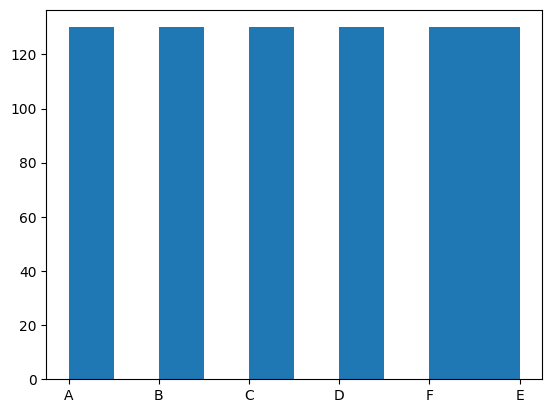

In [37]:
train_data = pd.read_csv("./dataset/train_Mod.csv")
test_data = pd.read_csv("./dataset/test.csv")

# 外れ値の除去
# 外れ値を削除
train_data = train_data[train_data['knee_depth'] < 17.5]
train_data = train_data[train_data['jump_height'] < 80]

# 欠損値を持つ行を削除
train_data = train_data.dropna()

#最初の６列をXとして格納
X = train_data.iloc[:, 1:6]
X_test = train_data.iloc[:, 1:6]
#最後の列をyとして格納
y = train_data.iloc[:, -1]

#アップサンプリング
sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)

#各データの分布を確認
plt.hist(y)
print(y.value_counts())


In [38]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

poly = PolynomialFeatures(degree=3, include_bias=False).fit(X_train_scaled)
X_train_poly = poly.transform(X_train_scaled)
X_val_poly = poly.transform(X_val_scaled)
X_test_poly = poly.transform(X_test_scaled)


In [39]:
import lightgbm as lgb

param = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 5, 6],
    'n_estimators': [50, 100, 150]
}

# LightGBMのモデルを作成
lgbm = lgb.LGBMClassifier(objective='multiclass', num_class=6)

# GridSearchCVの設定
grid_search = GridSearchCV(lgbm, param, cv=3, n_jobs=-1)

# ハイパーパラメータ探索
grid_search.fit(X_train_poly, y_train)

# 最適なパラメータとその時のスコアを表示
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

# 最適なパラメータでモデルを訓練
best_lgbm = grid_search.best_estimator_

# 検証データで評価
y_pred = best_lgbm.predict(X_val_poly)
accuracy = accuracy_score(y_val, y_pred)
print(f"Valid accuracy: {accuracy}")

#テストデータをcsv化
test_data = test_data.iloc[:, 1:6]
test_data_scaled = scaler.transform(test_data)
test_data_poly = poly.transform(test_data_scaled)
y_pred_test = best_lgbm.predict(test_data_poly)
y_pred_test = pd.DataFrame(y_pred_test)
#第１列は'id', 第２列は'personal_id'という列名をつける
y_pred_test.columns = ['personal_id']
#idは0起算
y_pred_test['id'] = y_pred_test.index
y_pred_test = y_pred_test.reindex(columns=['id', 'personal_id'])
y_pred_test.to_csv('submit15.csv', index=False)



[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11440
[LightGBM] [Info] Number of data points in the train set: 624, number of used features: 55
[LightGBM] [Info] Start training from score -1.882273
[LightGBM] [Info] Start training from score -1.821030
[LightGBM] [Info] Start training from score -1.735670
[LightGBM] [Info] Start training from score -1.744802
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.782190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

In [40]:
#XGBoost
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# 1. データの準備
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)

param = {
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [3, 4, 5],
    'classifier__min_child_weight': [1, 2, 3],
    'classifier__gamma': [0, 0.1, 0.2],
    'classifier__subsample': [0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.8, 0.9, 1.0]
}

pipeline = Pipeline([
    ('classifier', XGBClassifier(eval_metric='mlogloss'))  # ステップ3: XGBoost
])

model = GridSearchCV(pipeline, param, cv=3, scoring='accuracy', n_jobs=-1)
model.fit(X_train_poly, y_train_encoded)

#最適なパラメータを表示
print("the best param is : ", model.best_params_)
print("the best score is : ", model.best_score_)
#検証データで評価
y_pred = model.predict(X_val_poly)
print("valid accuracy_score : ", accuracy_score(y_val_encoded, y_pred))

best_xgb = model.best_estimator_

#CSV可
y_pred_test = best_xgb.predict(test_data_poly)
#予測値をデコード
y_pred_test = le.inverse_transform(y_pred_test)
y_pred_test = pd.DataFrame(y_pred_test)
#第１列は'id', 第２列は'personal_id'という列名をつける
y_pred_test.columns = ['personal_id']
#idは0起算
y_pred_test['id'] = y_pred_test.index
y_pred_test = y_pred_test.reindex(columns=['id', 'personal_id'])
y_pred_test.to_csv('submit16.csv', index=False)

the best param is :  {'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0, 'classifier__learning_rate': 0.2, 'classifier__max_depth': 3, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 150, 'classifier__subsample': 0.8}
the best score is :  0.8189102564102564
valid accuracy_score :  0.8717948717948718


In [18]:
#ランダムフォレスト
from sklearn.ensemble import RandomForestClassifier

# パイプラインの作成
pipe = Pipeline([
    ('random_forest', RandomForestClassifier())
])

# グリッドサーチのパラメータ
param_grid = {
    'random_forest__n_estimators': [10, 50, 100],  # 木の数
    'random_forest__max_depth': [None, 10, 20, 30],     # 木の最大深さ
    'random_forest__min_samples_split': [5, 10, 20],     # 内部ノードを分割するための最小サンプル数
    'random_forest__min_samples_leaf': [1, 2, 4],       # 葉ノードに必要な最小サンプル数
    'random_forest__max_features': ['sqrt'],    # 最適な分割を探す際に考慮する特徴量の数
}

# GridSearchCVの設定
grid_search = GridSearchCV(pipe, param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# グリッドサーチの実行
grid_search.fit(X_train_poly, y_train)

# 最適なパラメータとその時のスコアを表示
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

# 最適なパラメータでモデルを訓練
best_rf = grid_search.best_estimator_

# テストデータで評価
y_pred = best_rf.predict(X_val_poly)
accuracy = accuracy_score(y_val, y_pred)
print(f"Valid accuracy: {accuracy}")

Best parameters: {'random_forest__max_depth': 10, 'random_forest__max_features': 'sqrt', 'random_forest__min_samples_leaf': 1, 'random_forest__min_samples_split': 5, 'random_forest__n_estimators': 50}
Best score: 0.826923076923077
Valid accuracy: 0.8461538461538461


In [44]:
#岡野さんのLogisticを導入

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(multi_class='multinomial', penalty='l2', C=1024, max_iter=5000)
lr.fit(X_train_poly,y_train)

best_logi = lr

In [46]:
# アンサンブル学習の適用

from sklearn.ensemble import VotingClassifier

#アンサンブル学習のパラメータをGridSearch

param = {
    'voting': ['hard', 'soft']
}

# VotingClassifierのモデルを作成
vc = VotingClassifier(estimators=[('xgb', best_xgb), ('logi', best_logi), ('rf', best_rf), ('lgbm', best_lgbm)])

# GridSearchCVの設定
grid_search = GridSearchCV(vc, param, cv=3, scoring='accuracy', n_jobs=-1) 
grid_search.fit(X_train_poly, y_train)

# 最適なパラメータとその時のスコアを表示
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

#検証データで評価
y_pred = grid_search.predict(X_val_poly)
print(f"Valid accuracy: {accuracy_score(y_val, y_pred)}")

#CSV化
y_pred_test = grid_search.predict(test_data_poly)
y_pred_test = pd.DataFrame(y_pred_test)
#第１列は'id', 第２列は'personal_id'という列名をつける
y_pred_test.columns = ['personal_id']
#idは0起算
y_pred_test['id'] = y_pred_test.index
y_pred_test = y_pred_test.reindex(columns=['id', 'personal_id'])
y_pred_test.to_csv('submit18.csv', index=False)




[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11440
[LightGBM] [Info] Number of data points in the train set: 624, number of used features: 55
[LightGBM] [Info] Start training from score -1.882273
[LightGBM] [Info] Start training from score -1.821030
[LightGBM] [Info] Start training from score -1.735670
[LightGBM] [Info] Start training from score -1.744802
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.782190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

In [34]:
# テストデータの予測

y_pred = best_lgbm.predict(X_test_poly)

#csv化
submission = pd.DataFrame({'id': test_data['id'], 'personal_id': y_pred})
submission.to_csv('submit15.csv', index=False)
#indexの列は'id',モデル予測値の列は'personal_id'という名前でDataFrameを作成
#submission = pd.DataFrame({'id': test_data['id'], 'personal_id': y_pred})

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


ValueError: array length 604 does not match index length 120